In [12]:
# sphinx_gallery_thumbnail_number = 9

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

import os

import matplotlib.pyplot as plt
import mne
import numpy as np
from nilearn.plotting import plot_design_matrix

import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels, picks_pair_to_idx
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

# run scalp quality test firstt!!

In [13]:
datapath = 'subjects/sub-013/ses-01/nirs'
raw_intensity = mne.io.read_raw_nirx(datapath).load_data()
#raw_intensity.resample(0.7)


Loading subjects/sub-013/ses-01/nirs
Reading 0 ... 7253  =      0.000 ...  1392.576 secs...


C:\Users\sarab\AppData\Local\Temp\ipykernel_20696\2099471623.py:2: RuntimeWarning: Extraction of measurement date from NIRX file failed. This can be caused by files saved in certain locales (currently only ['en_US.utf8', 'de_DE', 'fr_FR', 'it_IT'] supported). Please report this as a github issue. The date is being set to January 1st, 2000, instead of '"6. feb 2025""11:01:55.270"'.
  raw_intensity = mne.io.read_raw_nirx(datapath).load_data()


In [14]:
raw_intensity.annotations

<Annotations | 67 segments: 1.0 (20), 2.0 (20), 3.0 (20), 4.0 (3), 5.0 (4)>

In [15]:
# need to confirm this
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Noise", "3.0": "Speech", '4.0': 'Stop', '5.0': 'Start'}
)
raw_intensity.annotations.delete(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.set_durations(5)

<Annotations | 67 segments: Control (20), Noise (20), Speech (20), Start ...>

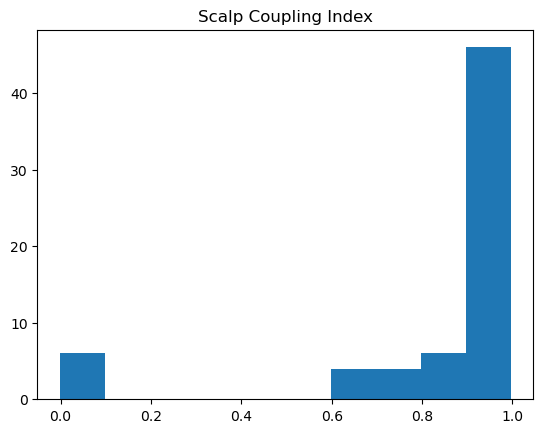

In [16]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

sci= mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax= plt.subplots()
ax.hist(sci)
ax.set_title('Scalp Coupling Index')
plt.show()


In [17]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6.1)
raw_haemo = get_long_channels(raw_haemo)

In [18]:
raw_haemo

<RawNIRX | nirs, 50 x 7254 (1392.8 s), ~2.8 MiB, data loaded>

In [19]:
# plot raw_haemo
raw_haemo.plot(n_channels=50, duration=500, show_scrollbars=False)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 393.216 (s)
Plotting power spectral density (dB=True).


c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


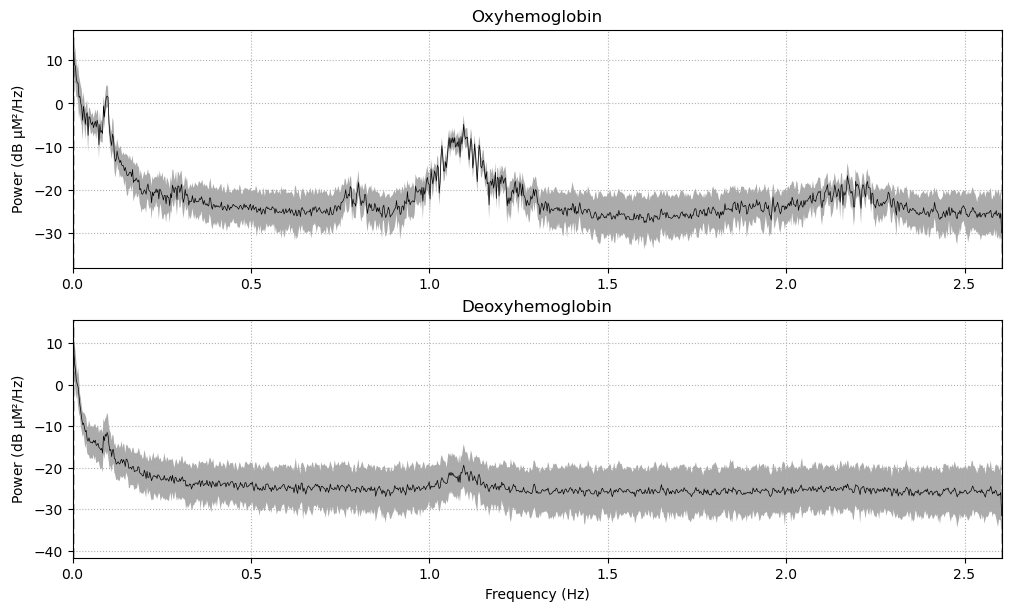

In [20]:
fig= raw_haemo.plot_psd(average=True)
plt.show()

In [21]:
# apply low pass and high pass freq
raw_haemo_filtered1= raw_haemo.filter(0.05, h_freq=None)
raw_haemo_filtered2= raw_haemo_filtered1.filter(l_freq= None, h_freq=0.3)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.05 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Filter length: 345 samples (66.240 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.30 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.30 Hz)
- Filter length: 9 samples (1.728 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 393.216 (s)
Plotting power spectral density (dB=True).


c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


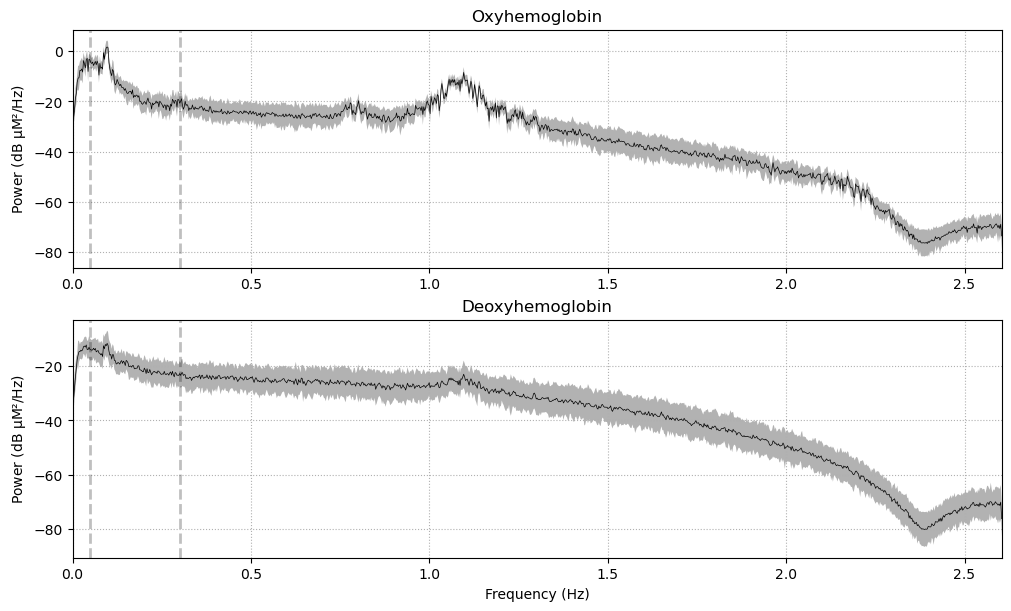

In [22]:
fig= raw_haemo_filtered2.compute_psd().plot(average=True)
# plot the fig
plt.show()




In [23]:
short_chs = get_short_channels(raw_haemo_filtered2)
raw_haemo_filtered2 = get_long_channels(raw_haemo_filtered2)

ValueError: No appropriate channels found for the given picks (array([], dtype=int64))

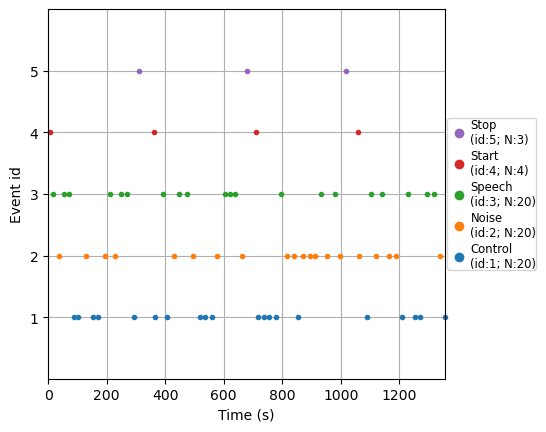

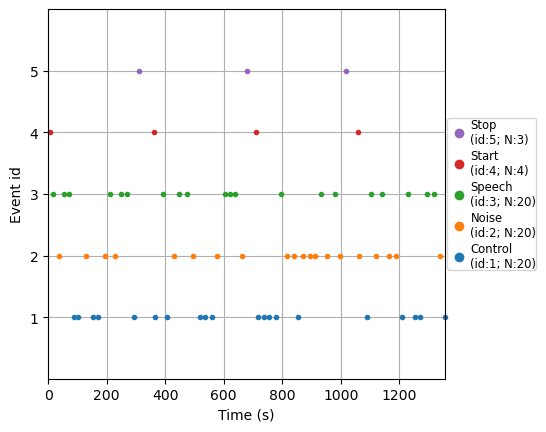

In [ ]:
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info["sfreq"])

Used Annotations descriptions: [np.str_('Control'), np.str_('Noise'), np.str_('Speech'), np.str_('Start'), np.str_('Stop')]


Text(0.5, 0, 'Time (s)')

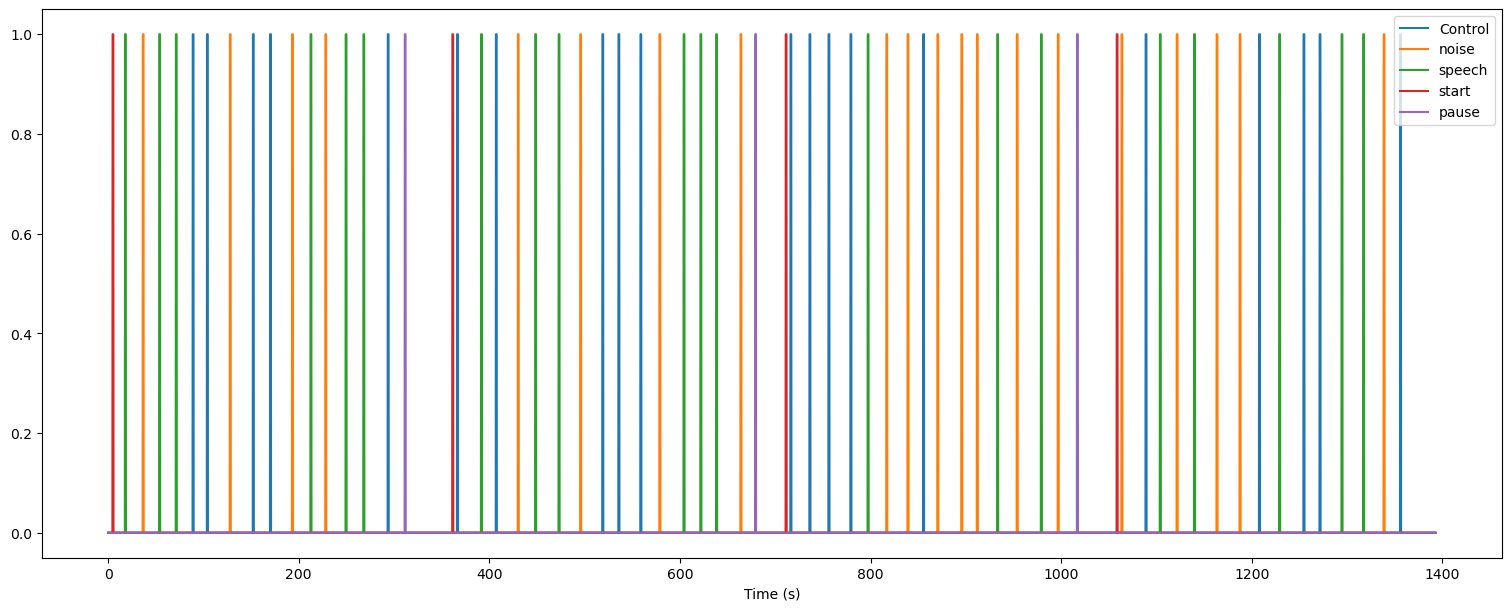

In [ ]:
s = mne_nirs.experimental_design.create_boxcar(raw_haemo)
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
ax.plot(raw_haemo.times, s)
ax.legend(["Control", "noise", "speech", 'start', 'pause'], loc="upper right")
ax.set_xlabel("Time (s)")

In [ ]:
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    drift_model="cosine",
    high_pass=0.005,  # Must be specified per experiment
    hrf_model="spm",
    stim_dur=5.0,
)

In [ ]:
design_matrix["ShortHbO"] = np.mean(
    short_chs.copy().pick(picks="hbo").get_data(), axis=0
)

design_matrix["ShortHbR"] = np.mean(
    short_chs.copy().pick(picks="hbr").get_data(), axis=0
)

Channels marked as bad:
none


C:\Users\sarab\AppData\Local\Temp\ipykernel_13072\1044303472.py:2: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  fig = plot_design_matrix(design_matrix, ax=ax1)


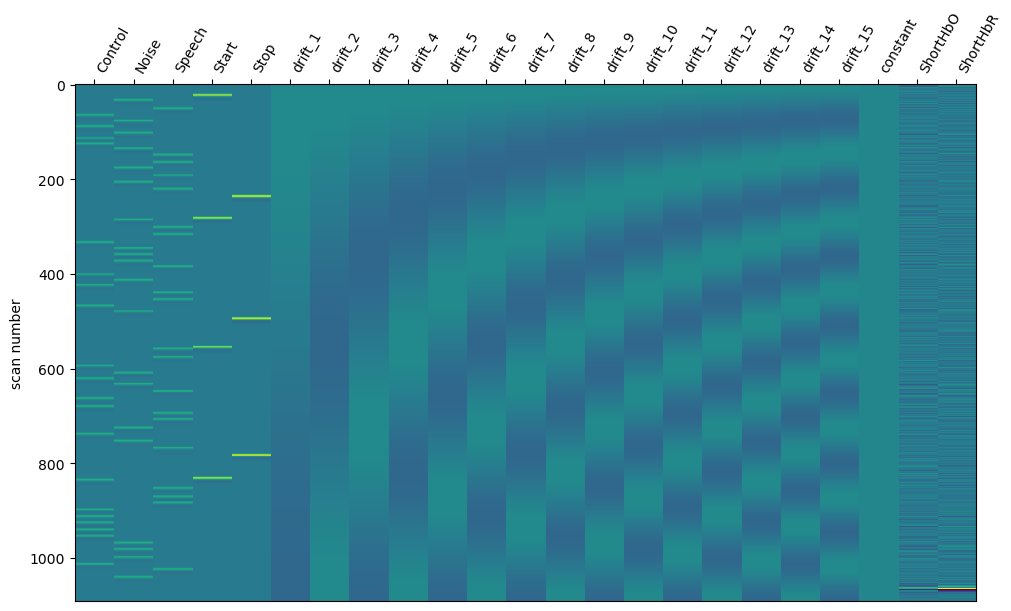

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, ax=ax1)

Used Annotations descriptions: [np.str_('Control'), np.str_('Noise'), np.str_('Speech'), np.str_('Start'), np.str_('Stop')]


[(180.0, 300.0), Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Amplitude')]

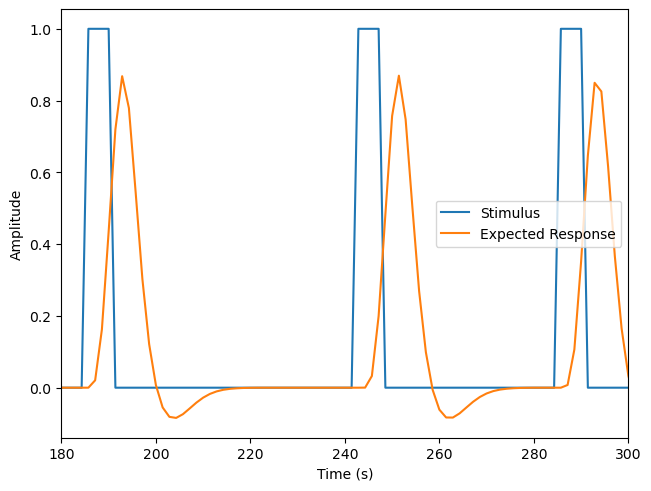

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=5.0)
ax.plot(raw_intensity.times, s[:, 1])
ax.plot(design_matrix["Noise"])
ax.legend(["Stimulus", "Expected Response"])
ax.set(xlim=(180, 300), xlabel="Time (s)", ylabel="Amplitude")

In [ ]:
data_subset = raw_haemo.copy().pick(picks=range(2))
glm_est = run_glm(data_subset, design_matrix)

In [ ]:
glm_est

GLM Results for 2 channels

In [ ]:
glm_est.copy().pick("S1_D1 hbr")

GLM Results for 1 channels

In [ ]:
glm_est.MSE()

[np.float64(1.0835369134951438e-12), np.float64(3.6931161443023085e-13)]

In [ ]:
glm_est.to_dataframe().head(9)

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Control,23.0,1.083537e-12,0.999401,2.800954e-07,0.000758,2.124411e-10,1,1,hbo,False,S1_D1 hbo
1,Noise,23.0,1.083537e-12,0.855225,2.753641e-07,-0.184517,-5.080937e-08,1,1,hbo,False,S1_D1 hbo
2,ShortHbO,23.0,1.083537e-12,0.000042,1.827159e-02,5.041110,9.210911e-02,1,1,hbo,True,S1_D1 hbo
3,ShortHbR,23.0,1.083537e-12,0.000002,1.592987e-02,6.228779,9.922361e-02,1,1,hbo,True,S1_D1 hbo
4,Speech,23.0,1.083537e-12,0.940047,2.746596e-07,0.076037,2.088431e-08,1,1,hbo,False,S1_D1 hbo
5,Start,23.0,1.083537e-12,0.995855,5.919330e-07,0.005252,3.108672e-09,1,1,hbo,False,S1_D1 hbo
6,Stop,23.0,1.083537e-12,0.373118,6.841766e-07,0.908342,6.214660e-07,1,1,hbo,False,S1_D1 hbo
7,constant,23.0,1.083537e-12,0.942861,7.209036e-08,-0.072461,-5.223765e-09,1,1,hbo,False,S1_D1 hbo
8,drift_1,23.0,1.083537e-12,0.991003,2.084456e-06,0.011400,2.376196e-08,1,1,hbo,False,S1_D1 hbo


<Axes: xlabel='Condition', ylabel='Theta'>

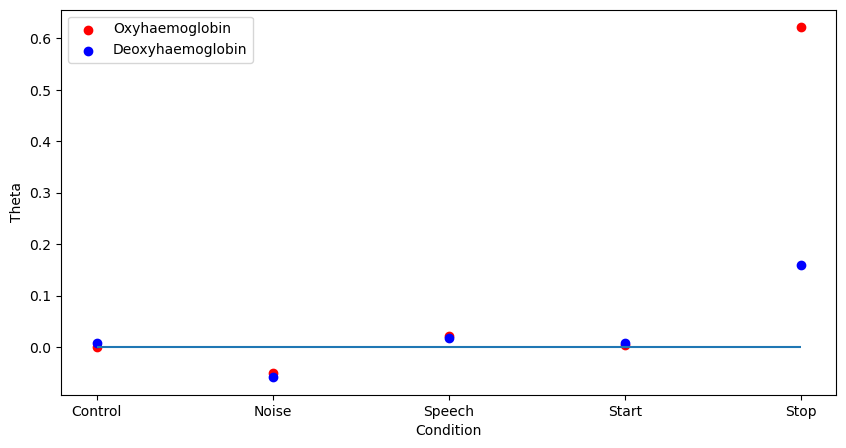

In [ ]:
glm_est.scatter()

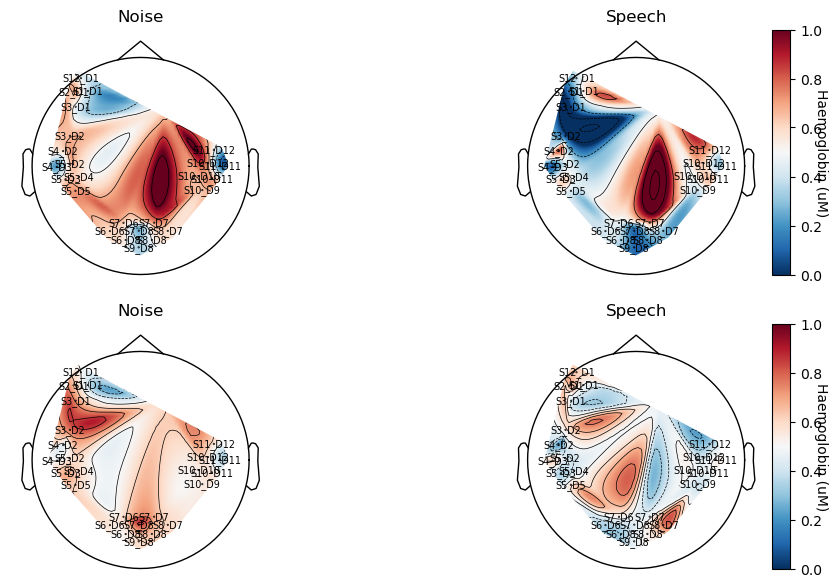

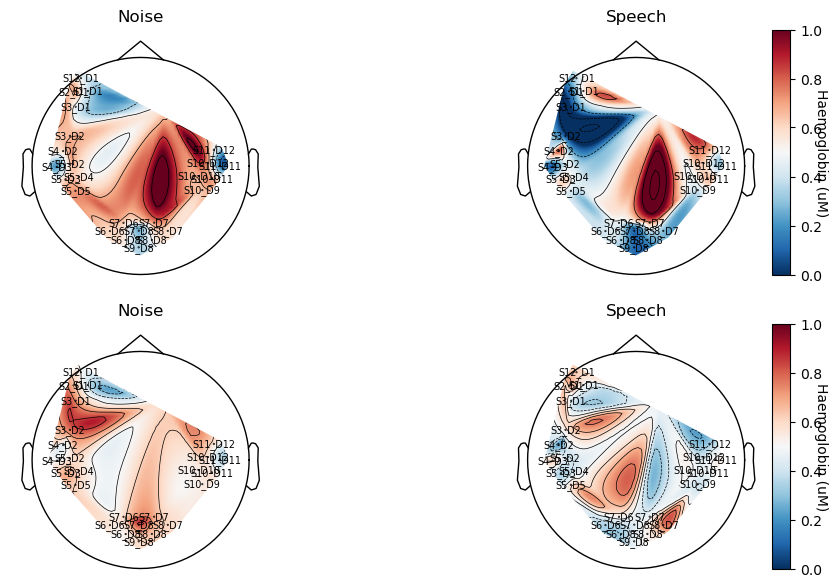

In [ ]:
glm_est = run_glm(raw_haemo, design_matrix)
glm_est.plot_topo(conditions=["Noise", "Speech"])

Text(0.5, 1.0, 'Hemispheres plotted independently')

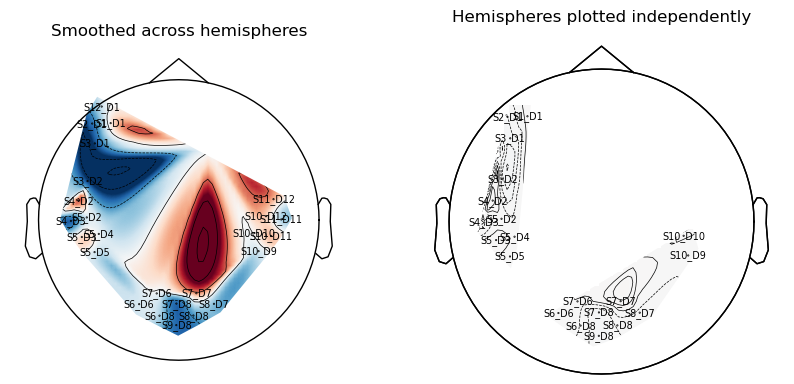

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1])
)

glm_hbo = glm_est.copy().pick(picks="hbo")
conditions = ["Speech"]

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions)

glm_hbo.copy().pick(picks=range(10)).plot_topo(
    conditions=conditions, axes=axes[1], colorbar=False, vlim=(-16, 16)
)
glm_hbo.copy().pick(picks=range(10, 20)).plot_topo(
    conditions=conditions, axes=axes[1], colorbar=False, vlim=(-16, 16)
)

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

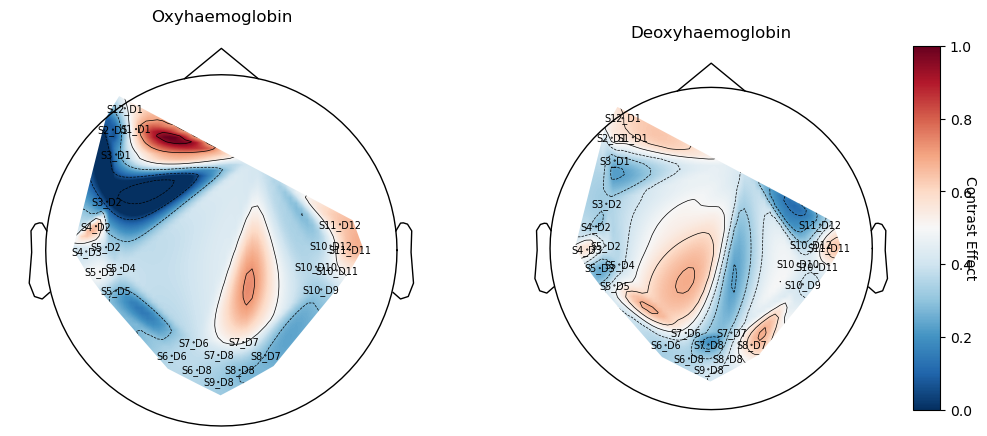

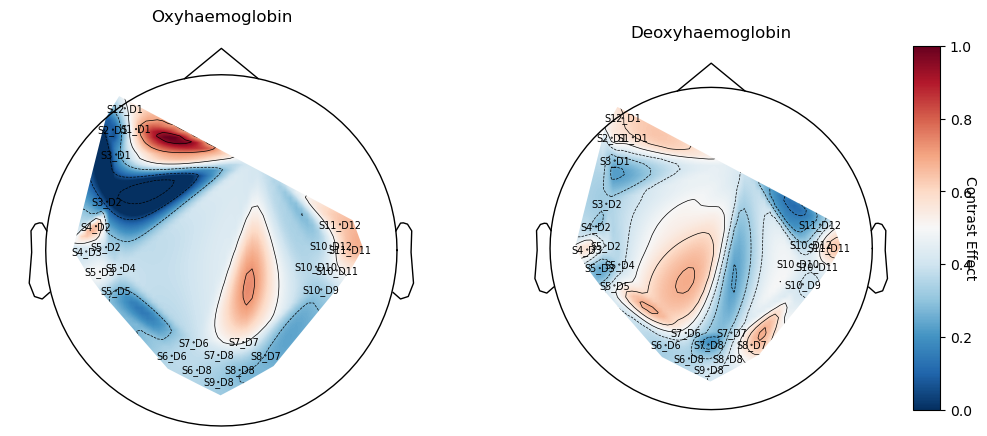

In [ ]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_conts = dict(
    [(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)]
)
contrast_LvR = basic_conts["Speech"] - basic_conts["Noise"]

contrast = glm_est.compute_contrast(contrast_LvR)
contrast.plot_topo()

In [ ]:
df = glm_est.to_dataframe()
(
    df.query('Condition in ["Control", "Noise", "Speech"]')
    .drop(["df", "mse", "p_value", "t"], axis=1)
    .groupby(["Condition", "Chroma", "ch_name"])
    .agg(["mean"])
)

variable                                se         theta Source Detector  \
                                      mean          mean   mean     mean   
Condition Chroma ch_name                                                   
Control   hbo    S10_D10 hbo  2.741810e-07 -2.374568e-08   10.0     10.0   
                 S10_D11 hbo  3.702136e-07 -3.688709e-08   10.0     11.0   
                 S10_D12 hbo  1.234620e-07 -6.560577e-08   10.0     12.0   
                 S10_D9 hbo   1.507820e-07 -5.428455e-08   10.0      9.0   
                 S11_D11 hbo  2.425967e-07 -2.899522e-09   11.0     11.0   
...                                    ...           ...    ...      ...   
Speech    hbr    S7_D7 hbr    3.510193e-07 -8.587287e-09    7.0      7.0   
                 S7_D8 hbr    2.706952e-07 -1.692155e-08    7.0      8.0   
                 S8_D7 hbr    4.339555e-07  9.461542e-08    8.0      7.0   
                 S8_D8 hbr    2.641144e-07  1.182660e-08    8.0      8.0   
                 S9_D8 hbr    2.116050e-07 -1.144566e-08    9.0      8.0   

variable                     Significant  
                                    mean  
Condition Chroma ch_name                  
Control   hbo    S10_D10 hbo         0.0  
                 S10_D11 hbo         0.0  
                 S10_D12 hbo         0.0  
                 S10_D9 hbo          0.0  
                 S11_D11 hbo         0.0  
...                                  ...  
Speech    hbr    S7_D7 hbr           0.0  
                 S7_D8 hbr           0.0  
                 S8_D7 hbr           0.0  
                 S8_D8 hbr           0.0  
                 S9_D8 hbr           0.0  

[150 rows x 5 columns]